<a href="https://colab.research.google.com/github/Teratoma111/amazon_review_analysis/blob/main/active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchtext.legacy import data
import numpy as np  
import torch.optim as optim
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(include_lengths = True,
                  tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField()
INDEX = data.LabelField()
from google.colab import drive
drive.mount('/content/drive')
import random

fields = {'reviewText': ('text', TEXT), 'overall': ('label', LABEL), 'index': ('index', INDEX)}
train_data = data.TabularDataset.splits(
                                        path = '/content/drive/MyDrive',
                                        train = "Musical_Instruments_5(mod).json",
                                        format = 'json',
                                        fields = fields)[0]
    
for i in range(0, len(train_data)):
  if(len(train_data[i].text) < 1):
    train_data[i].text = train_data[3].text
    train_data[i].label = train_data[3].label
origin_data = train_data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.fc(hidden)

In [3]:
def get_weights(iterator):
  weights = torch.zeros(len(LABEL.vocab))
  for batch in iterator:
    for i in batch.label:
      weights[i.cpu().numpy()] +=1
  for i in range(0, len(LABEL.vocab)):
    weights[i] = (1 / weights[i]) * 100
  return weights

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
def categorical_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    y_score = top_pred.detach().cpu().numpy()
    y_true = y.view_as(top_pred).cpu().numpy()
    f1 = f1_score(y_true, y_score, average = 'weighted')
    rec = recall_score(y_true, y_score, average = 'weighted')
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return (rec, f1, acc)

In [5]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_rec = 0
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        metrics = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        acc = metrics[2]
        f1 = metrics[1]
        rec = metrics[0]
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1
        epoch_rec += rec
    epoch_acc /= len(iterator)
    epoch_f1 /= len(iterator)
    epoch_rec /= len(iterator)
    return epoch_loss / len(iterator), (epoch_rec, epoch_f1, epoch_acc)

In [6]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_rec = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.label)
            
            metrics = categorical_accuracy(predictions, batch.label)

            acc = metrics[2]
            f1 = metrics[1]
            rec = metrics[0]
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1
            epoch_rec += rec
        epoch_acc /= len(iterator)
        epoch_f1 /= len(iterator)
        epoch_rec /= len(iterator)
        
    return epoch_loss / len(iterator), (epoch_rec, epoch_f1, epoch_acc)

In [7]:
from torchtext.legacy import data
TEXT.build_vocab(train_data, 
                 vectors = "fasttext.simple.300d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)
INDEX.build_vocab(train_data)
TEXT1 = data.Field(include_lengths = True,
                  tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL1 = data.LabelField()
INDEX1 = data.LabelField()
field = {('text', TEXT1),('label', LABEL1), ('index', INDEX1)}

train_data, valid_data = train_data.split(random_state = random.seed(SEED))
train_data_arr = np.array(train_data.examples)
l = list(range(0, len(train_data)))
random.shuffle(l)
rand_data =  data.Dataset(train_data_arr[l[-200:]], fields=field)
TEXT1.build_vocab(train_data, 
                 vectors = "fasttext.simple.300d", 
                 unk_init = torch.Tensor.normal_)
LABEL1.build_vocab(train_data)
INDEX1.build_vocab(train_data)
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator= data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True, 
    device = device)

In [8]:
  pretrained_embeddings = TEXT.vocab.vectors
  INPUT_DIM = len(TEXT.vocab)
  EMBEDDING_DIM = 300
  HIDDEN_DIM = 256
  OUTPUT_DIM = len(LABEL.vocab)
  N_LAYERS = 2
  BIDIRECTIONAL = True
  DROPOUT = 0.55
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
  model = RNN(INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX)
  model.embedding.weight.data.copy_(pretrained_embeddings)
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

  optimizer = optim.Adam(model.parameters())

  criterion = nn.CrossEntropyLoss(weight =  get_weights(train_iterator))
  #criterion = nn.CrossEntropyLoss()
  model = model.to(device)
  criterion = criterion.to(device)

In [9]:
from torchtext.legacy import data
TEXT1.build_vocab(rand_data, 
                 vectors = "fasttext.simple.300d", 
                 unk_init = torch.Tensor.normal_)
LABEL1.build_vocab(rand_data)
INDEX1.build_vocab(rand_data)


rand_iterator, valid_iterator = data.BucketIterator.splits(
    (rand_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    #sort_within_batch = False,
    sort_within_batch = True, 
    device = device)

In [10]:
import time
from torchtext import data, datasets
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [11]:
N_EPOCHS = 15
best_valid_score = float('0')
best_f1 = float('0')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_res = train(model, rand_iterator, optimizer, criterion)
    train_loss = train_res[0]
    train_score = train_res[1]
    valid_res = evaluate(model, valid_iterator, criterion)
    valid_score = valid_res[1]
    valid_loss = valid_res[0]
    end_time = time.time()
    valid_acc = (valid_score[1])
    acc = valid_acc
    #print(float(valid_acc))
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    if acc > best_valid_score:
        best_valid_score= acc
        best_f1 = valid_score[1]*100
        torch.save(model.state_dict(), '/content/drive/MyDrive/mo1.pt')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid F1: {valid_score[1]*100:.2f}% | Valid rec: {valid_score[0]*100:.2f}% | Valid acc: {valid_score[2]*100:.2f}%')
    print(f'\tTrain Loss: {train_loss:.3f} | Train F1: {train_score[1]*100:.2f}% | Train rec: {train_score[0]*100:.2f}% | Train acc: {train_score[2]*100:.2f}%')
print("--------------------------------")
print(best_valid_score, best_f1)

Epoch: 01 | Epoch Time: 0m 1s
	Valid Loss: 1.610 | Valid F1: 52.01% | Valid rec: 63.03% | Valid acc: 63.03%
	Train Loss: 1.605 | Train F1: 42.42% | Train rec: 37.41% | Train acc: 37.41%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.585 | Train F1: 54.35% | Train rec: 56.86% | Train acc: 56.86%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.565 | Train F1: 44.59% | Train rec: 40.71% | Train acc: 40.71%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.541 | Train F1: 22.20% | Train rec: 17.06% | Train acc: 17.06%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.523 | Train F1: 1.58% | Train rec: 3.95% | Train acc: 3.95%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.508 | Train F1: 1.75% | Train rec: 4.04% | Train acc: 4.04%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.466 | Train F1: 3.61% | Train rec: 5.03% | Train acc: 5.03%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.353 | Train F1: 12.39% | Train rec: 10.63% | Train acc: 10.63%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.264 | Train F1: 30.26% | Train rec: 23.70% | Train acc: 23.70%
Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.099 | Train F1: 48.77% | Train rec: 42.88% | Train acc: 42.88%
Epoch: 11 | Epoch Time: 0m 1s
	Train Loss: 0.980 | Train F1: 54.52% | Train rec: 48.61% | Train acc: 48.61%
Epoch: 12 | Epoch Time: 0m 1s
	Train Loss: 0.830 | Train F1: 60.14% | Train rec: 57.25% | Train acc: 57.25%
Epoch: 13 | Epoch Time: 0m 1s
	Train Loss: 0.692 | Train F1: 63.08% | Train rec: 60.55% | Train acc: 60.55%
Epoch: 14 | Epoch Time: 0m 1s
	Train Loss: 0.672 | Train F1: 55.74% | Train rec: 52.69% | Train acc: 52.69%
Epoch: 15 | Epoch Time: 0m 1s
	Train Loss: 0.603 | Train F1: 62.46% | Train rec: 59.55% | Train acc: 59.55%
--------------------------------
0.5200926331800818 52.00926331800818


In [12]:
from torchtext.legacy import data
train_iterator, valid_iterator= data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True, 
    device = device)
train_id = []

In [13]:
def get_train_least_data(model, train_iterator, train_data):  
  bf = [(0, 0.000001)]
  a = np.array(bf,dtype = [('index', int) , ('prob', float)])
  with torch.no_grad():
    for batch in train_iterator:
      text, text_lengths = batch.text
      preds = model(text, text_lengths)
      preds_sorted, idxs = preds.sort(descending=True)
      U = preds.max(1)[0]
      for i in range(0, len(batch)):
        j = i
        hu = float(U.cpu().numpy()[j])
        nuf = int(batch.index.cpu().numpy()[i])
        b = np.array([(nuf, hu)],dtype = [('index', int) , ('prob', float)])
        a = np.concatenate((a, b))
    a = np.array(a,dtype = [('index', int) , ('prob', float)])
    a.sort(order = 'prob')
    train_data_arr = np.array(train_data.examples)
    inds = a[-200:]['index']
    for i_1 in inds:
      for i_2 in range(0, len(train_data_arr)):
        print
        if( i_1 == vars(train_data_arr[i_2])['index']):
          train_id.append(i_2)
    return train_id

In [34]:
def get_rand_data(k):
  l = list(range(0, len(train_data)))
  random.shuffle(l)
  t = k*(-200)
  return l[t:]

In [14]:
def get_train_margin_data(model, train_iterator, train_data):  
  bf = [(0, 0.000001)]
  a = np.array(bf,dtype = [('index', int) , ('prob', float)])
  with torch.no_grad():
    for batch in train_iterator:
      text, text_lengths = batch.text
      preds = model(text, text_lengths)
      preds_sorted, idxs = preds.sort(descending=True)
      U = (preds_sorted[:, 0] - preds_sorted[:,1])
      for i in range(0, len(batch)):
        j = i
        hu = float(U.cpu().numpy()[j])
        nuf = int(batch.index.cpu().numpy()[i])
        b = np.array([(nuf, hu)],dtype = [('index', int) , ('prob', float)])
        a = np.concatenate((a, b))
    a = np.array(a,dtype = [('index', int) , ('prob', float)])
    a.sort(order = 'prob')
    train_data_arr = np.array(train_data.examples)
    inds = a[-200:]['index']
    for i_1 in inds:
      for i_2 in range(0, len(train_data_arr)):
        print
        if( i_1 == vars(train_data_arr[i_2])['index']):
          train_id.append(i_2)
    return train_id

In [15]:
def get_train_entropy_data(model, train_iterator, train_data):  
  bf = [(0, 0.000001)]
  a = np.array(bf,dtype = [('index', int) , ('prob', float)])
  with torch.no_grad():
    for batch in train_iterator:
      text, text_lengths = batch.text
      preds = model(text, text_lengths)
      #preds_sorted, idxs = preds.sort(descending=True)
      log_probs = torch.log(preds)
      U = (preds*log_probs).sum(1)
      for i in range(0, len(batch)):
        j = i
        hu = float(U.cpu().numpy()[j])
        nuf = int(batch.index.cpu().numpy()[i])
        b = np.array([(nuf, hu)],dtype = [('index', int) , ('prob', float)])
        a = np.concatenate((a, b))
    a = np.array(a,dtype = [('index', int) , ('prob', float)])
    a.sort(order = 'prob')
    train_data_arr = np.array(train_data.examples)
    inds = a[-200:]['index']
    for i_1 in inds:
      for i_2 in range(0, len(train_data_arr)):
        print
        if( i_1 == vars(train_data_arr[i_2])['index']):
          train_id.append(i_2)
    return train_id

In [16]:
TEXT2 = data.Field(include_lengths = True,
                  tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL2 = data.LabelField()
INDEX2 = data.LabelField()
best_plot = []
for k in range(1, 10):
  field1 = {('text', TEXT2),('label', LABEL2), ('index', INDEX2)}
  to_data =  data.Dataset(train_data_arr[get_train_margin_data(model, train_iterator, train_data)], fields=field1)
  print(len(to_data))
  TEXT2.build_vocab(to_data, 
                  vectors = "fasttext.simple.300d", 
                  unk_init = torch.Tensor.normal_)
  LABEL2.build_vocab(to_data)
  INDEX2.build_vocab(train_data)
  INDEX2.build_vocab(to_data)
  to_iterator, valid_iterator = data.BucketIterator.splits(
      (to_data, valid_data), 
      batch_size = BATCH_SIZE,
      sort_key = lambda x: len(x.text),
      sort_within_batch = True, 
      device = device)
  N_EPOCHS = 15
  best_valid_score = float('0')
  best_f1 = float('0')
  for epoch in range(N_EPOCHS):
      start_time = time.time()
      train_res = train(model, to_iterator, optimizer, criterion)
      train_loss = train_res[0]
      train_score = train_res[1]
      valid_res = evaluate(model, train_iterator, criterion)
      valid_score = valid_res[1]
      valid_loss = valid_res[0]
      end_time = time.time()
      valid_acc = (valid_score[1])
      acc = valid_acc
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      if acc > best_valid_score:
          best_valid_score= acc
          best_f1 = valid_score[1]*100
          torch.save(model.state_dict(), '/content/drive/MyDrive/mo1.pt')
          print(f'\tValid Loss: {valid_loss:.3f} | Valid F1: {valid_score[1]*100:.2f}% | Valid rec: {valid_score[0]*100:.2f}% | Valid acc: {valid_score[2]*100:.2f}%')
      print(f'\tTrain Loss: {train_loss:.3f} | Train F1: {train_score[1]*100:.2f}% | Train rec: {train_score[0]*100:.2f}% | Train acc: {train_score[2]*100:.2f}%')
  print("--------------------------------")
  best_plot.append(best_f1)
  print(best_valid_score, best_f1)

200


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 2s
	Valid Loss: 2.163 | Valid F1: 23.92% | Valid rec: 19.53% | Valid acc: 19.53%
	Train Loss: 1.963 | Train F1: 36.06% | Train rec: 31.34% | Train acc: 31.34%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.713 | Train F1: 19.95% | Train rec: 17.40% | Train acc: 17.40%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.506 | Train F1: 7.01% | Train rec: 11.33% | Train acc: 11.33%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 1.428 | Train F1: 6.08% | Train rec: 10.16% | Train acc: 10.16%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.329 | Train F1: 10.76% | Train rec: 13.98% | Train acc: 13.98%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.231 | Train F1: 16.72% | Train rec: 20.36% | Train acc: 20.36%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 1.148 | Train F1: 14.78% | Train rec: 18.62% | Train acc: 18.62%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 1.012 | Train F1: 15.86% | Train rec: 24.00% | Train acc: 24.00%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.926 | Train F1:

In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/mo_feated.pt')

[47.63139506221057, 39.17560523491486, 44.21966379832531, 48.99235067458794, 51.30427666017637, 50.219093038489696, 50.900366187254555, 53.83634932325908, 53.05916097803334]
[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]


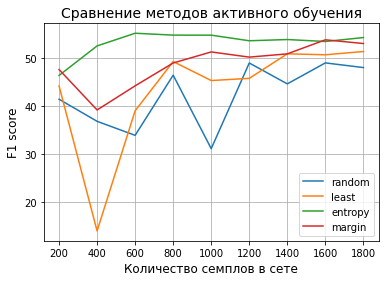

In [33]:
print(best_plot)
x_point = []
for temp in (range(1,10)):
  x_point.append(temp*200)
print(x_point)
import matplotlib.pyplot as plt
c = [46.38995074571485, 52.56085112637518, 55.209300946709185, 54.8176026075717, 54.807890192960244, 53.638978613138654, 53.89468740411485, 53.486672766493705, 54.306929582619766]
b = [41.41879029468296, 36.80400664846506, 33.87398524252482, 46.451210133985995, 31.0913319512153, 48.99422276834299, 44.6264596976801, 49.01078256127994, 48.036221460745345]
d = [44.20217926208369, 13.898955194534013, 39.01011958577592, 49.2912427133437, 45.32273380570593, 45.78397520732811, 50.90960072117569, 50.70831679678531, 51.39221702543496]
e = [47.63139506221057, 39.17560523491486, 44.21966379832531, 48.99235067458794, 51.30427666017637, 50.219093038489696, 50.900366187254555, 53.83634932325908, 53.05916097803334]
plt.plot(x_point, b, label = 'random', linestyle = '-')
plt.plot(x_point, d, label = "least", linestyle = '-')
plt.plot(x_point, c, label = "entropy", linestyle = '-')
plt.plot(x_point, e, label = "margin", linestyle = '-')
plt.title('Сравнение методов активного обучения', fontsize=14)
plt.ylabel('F1 score', fontsize=12)
plt.xlabel('Количество семплов в сете', fontsize=12)
plt.legend()
plt.grid(True)